   Order ID  Sales Document Order Status Order Date         Order Range  \
0    567309    1.000211e+09      Shipped   1/2/2024  Older than 5 weeks   
1    567586    1.000212e+09      Shipped   1/5/2024  Older than 5 weeks   
2    567631    1.000212e+09      Shipped   1/6/2024  Older than 5 weeks   
3    567812    1.000212e+09      Shipped   1/8/2024  Older than 5 weeks   
4    567965    1.000212e+09      Shipped   1/9/2024  Older than 5 weeks   

               Customer Email    Customer Name                  Club  \
0       donnadozois@gmail.com     Donna Dozois  Rush National Soccer   
1  glorimier@morushsoccer.com   Geoff Lorimier          Rush Coaches   
2      hrothmann@somdrush.org   Harry Rothmann          Rush Coaches   
3      lisakoconnor@gmail.com     Lisa OConnor              Rush Psd   
4       steveheddinger@me.com  Steve Heddinger              Rush Vsa   

   Master Club Shipped Quantity  ... Shipped Qty Unshipped Qty Club Name  \
0  Rush Soccer               3   ...    

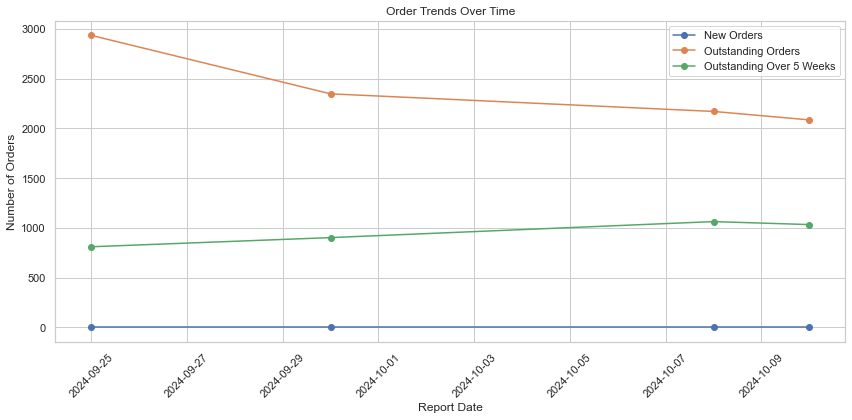

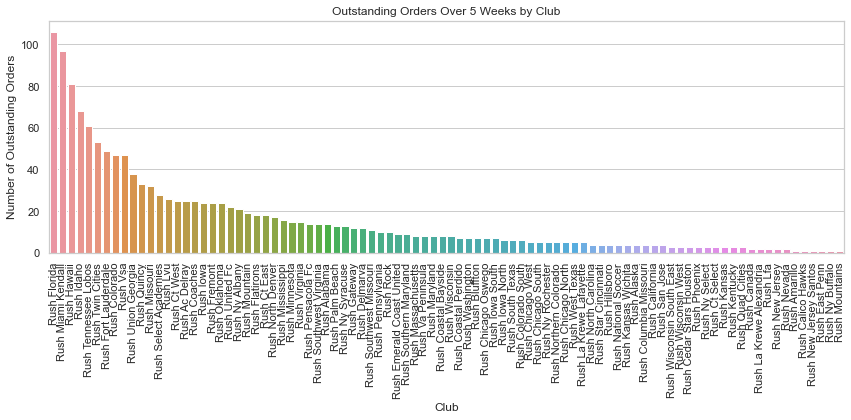

Average age of outstanding orders: 31.76 days


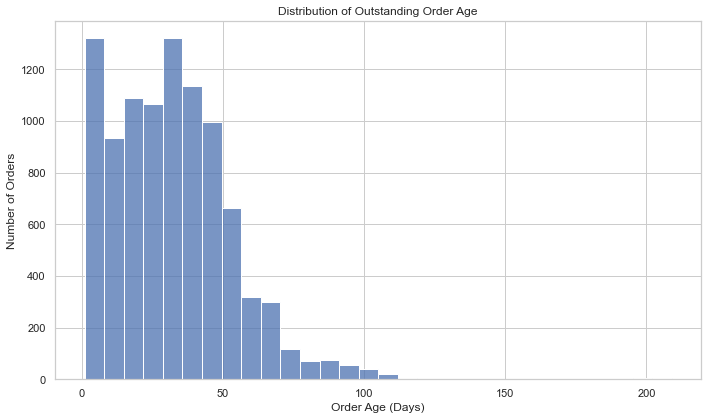

Total number of unique orders: 27089

Order Status Counts:
shipped    95172
open        9537
Name: Combined Order Status, dtype: int64

Top Clubs by Number of Orders:
                    Club  Order ID
31          Rush Florida      1395
92  Rush Tennessee Lobos      1157
37            Rush Idaho       947
35           Rush Hawaii       934
94    Rush Union Georgia       924


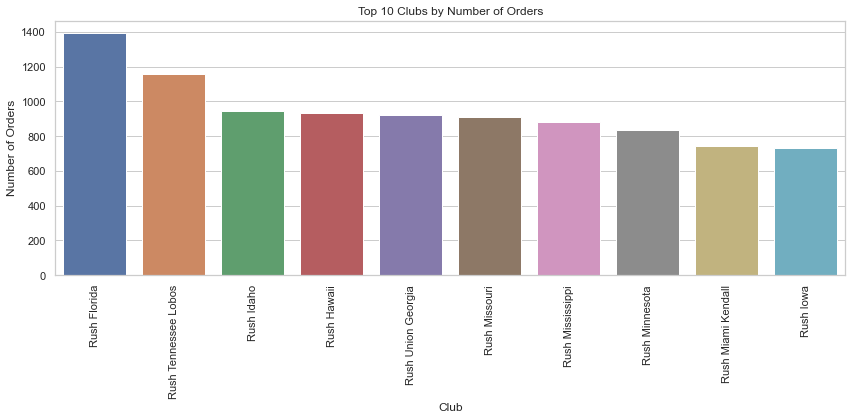


Trend Data:
  Report Date  New Orders  Outstanding Orders  Outstanding Over 5 Weeks  \
0  2024-09-25           0                2935                       810   
1  2024-09-30           0                2347                       902   
2  2024-10-08           0                2170                      1063   
3  2024-10-10           0                2085                      1033   

   Outstanding to New Orders Ratio  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  


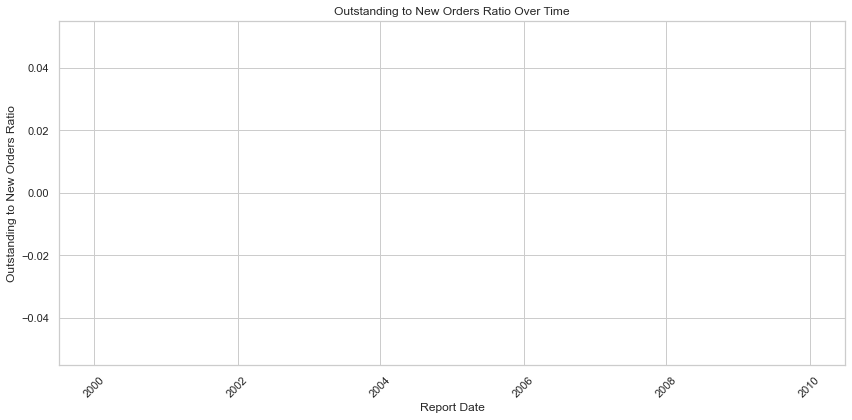


Insights:
- Total number of unique orders: 27089
- Total number of outstanding orders: 3589
- Number of outstanding orders over 5 weeks: 1459
- Average age of outstanding orders: 31.76 days
- The trend analysis shows how new orders and outstanding orders have changed over time.
- The ratio of outstanding to new orders helps understand the backlog.


In [6]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import os

# Set visualization style
sns.set(style='whitegrid')

# Step 1: Define the directory where reports are stored
report_dir = 'reports/'

# Step 2: List of report files in the "reports/" subdirectory
report_files = [
    'Master Capelli Report Sheet - 9_25_24 Orders.csv',
    'Master Capelli Report Sheet - 9_30_24 Orders.csv',
    'Master Capelli Report Sheet - 10_8_24 Orders.csv',
    'Master Capelli Report Sheet - 10_10_24 Orders.csv'
]

# Initialize an empty list to store DataFrames
df_list = []

for file in report_files:
    # Combine directory and file name
    file_path = os.path.join(report_dir, file)
    
    # Read each CSV file
    df = pd.read_csv(file_path)
    
    # Extract the report date from the filename using regex
    match = re.search(r'- (\d{1,2}_\d{1,2}_\d{2}) Orders\.csv', file)
    if match:
        date_str = match.group(1)
        # Convert date string to datetime object
        report_date = pd.to_datetime(date_str, format='%m_%d_%y')
    else:
        # If no date found, set to NaT (Not a Time)
        report_date = pd.NaT
    
    # Add the extracted report date to the DataFrame
    df['Report Date'] = report_date
    
    # Append the DataFrame to the list
    df_list.append(df)

# Combine all DataFrames into one
data = pd.concat(df_list, ignore_index=True)

# Check the combined data
print(data.head())


# Step 3: Preprocess Data
# Convert date columns to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data['Report Date'] = pd.to_datetime(data['Report Date'], errors='coerce')

# Ensure numeric columns are properly typed
numeric_columns = ['Shipped Quantity', 'Unshipped Quantity']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values
data.fillna({'Shipped Quantity': 0, 'Unshipped Quantity': 0}, inplace=True)
data['Combined Order Status'] = data['Combined Order Status'].fillna('Unknown')

# Standardize text columns
data['Order Status'] = data['Order Status'].str.strip().str.lower()
data['Combined Order Status'] = data['Combined Order Status'].str.strip().str.lower()

# Step 4: Identify Outstanding Orders Over 5 Weeks
# Define a function to categorize orders
def categorize_order(row):
    if row['Combined Order Status'] in ['open', 'partially shipped']:
        order_age = (row['Report Date'] - row['Order Date']).days
        if order_age > 35:  # 5 weeks * 7 days
            return 'Outstanding Over 5 Weeks'
        else:
            return 'Outstanding Under 5 Weeks'
    elif row['Combined Order Status'] == 'shipped':
        return 'Shipped'
    else:
        return 'Other'

# Apply the function to categorize orders
data['Order Category'] = data.apply(categorize_order, axis=1)

# Extract outstanding orders over 5 weeks into a DataFrame
outstanding_over_5_weeks_df = data[data['Order Category'] == 'Outstanding Over 5 Weeks']

# Calculate the number of unique outstanding orders over 5 weeks
num_outstanding_over_5_weeks = outstanding_over_5_weeks_df['Order ID'].nunique()
print(f"Total number of outstanding orders over 5 weeks: {num_outstanding_over_5_weeks}")

# Step 5: Analyze New Orders vs. Outstanding Orders
trend_data = []

for report_date in sorted(data['Report Date'].dropna().unique()):
    df_report = data[data['Report Date'] == report_date]
    
    # New orders are those with 'Order Date' equal to 'Report Date'
    new_orders_count = df_report[df_report['Order Date'] == report_date]['Order ID'].nunique()
    
    # Outstanding orders are those not yet shipped as of 'Report Date'
    outstanding_orders_count = df_report[df_report['Combined Order Status'].isin(['open', 'partially shipped'])]['Order ID'].nunique()
    
    # Outstanding orders over 5 weeks
    outstanding_over_5_weeks_count = df_report[df_report['Order Category'] == 'Outstanding Over 5 Weeks']['Order ID'].nunique()
    
    trend_data.append({
        'Report Date': report_date,
        'New Orders': new_orders_count,
        'Outstanding Orders': outstanding_orders_count,
        'Outstanding Over 5 Weeks': outstanding_over_5_weeks_count
    })

trend_df = pd.DataFrame(trend_data)

# Step 6: Trend Analysis
# Plot the trends over time
plt.figure(figsize=(12, 6))
plt.plot(trend_df['Report Date'], trend_df['New Orders'], marker='o', label='New Orders')
plt.plot(trend_df['Report Date'], trend_df['Outstanding Orders'], marker='o', label='Outstanding Orders')
plt.plot(trend_df['Report Date'], trend_df['Outstanding Over 5 Weeks'], marker='o', label='Outstanding Over 5 Weeks')
plt.title('Order Trends Over Time')
plt.xlabel('Report Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 7: Visualizations
# Bar chart of outstanding orders over 5 weeks by club
outstanding_by_club = outstanding_over_5_weeks_df.groupby('Club')['Order ID'].nunique().reset_index()
outstanding_by_club = outstanding_by_club.sort_values('Order ID', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=outstanding_by_club, x='Club', y='Order ID')
plt.title('Outstanding Orders Over 5 Weeks by Club')
plt.xlabel('Club')
plt.ylabel('Number of Outstanding Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 8: Additional Analysis
# Calculate the average age of outstanding orders
outstanding_orders_df = data[data['Combined Order Status'].isin(['open', 'partially shipped'])].copy()
outstanding_orders_df['Order Age (Days)'] = (outstanding_orders_df['Report Date'] - outstanding_orders_df['Order Date']).dt.days

average_age = outstanding_orders_df['Order Age (Days)'].mean()
print(f"Average age of outstanding orders: {average_age:.2f} days")

# Histogram of order age
plt.figure(figsize=(10, 6))
sns.histplot(outstanding_orders_df['Order Age (Days)'], bins=30)
plt.title('Distribution of Outstanding Order Age')
plt.xlabel('Order Age (Days)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Step 9: Comprehensive EDA
# Total number of orders
total_orders = data['Order ID'].nunique()
print(f"Total number of unique orders: {total_orders}")

# Orders by status
order_status_counts = data['Combined Order Status'].value_counts()
print("\nOrder Status Counts:")
print(order_status_counts)

# Orders by club
orders_by_club = data.groupby('Club')['Order ID'].nunique().reset_index().sort_values('Order ID', ascending=False)
print("\nTop Clubs by Number of Orders:")
print(orders_by_club.head())

# Plot orders by club
plt.figure(figsize=(12, 6))
sns.barplot(data=orders_by_club.head(10), x='Club', y='Order ID')
plt.title('Top 10 Clubs by Number of Orders')
plt.xlabel('Club')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Analyze the ratio of outstanding orders to new orders
trend_df['Outstanding to New Orders Ratio'] = trend_df['Outstanding Orders'] / trend_df['New Orders'].replace(0, np.nan)
print("\nTrend Data:")
print(trend_df)

plt.figure(figsize=(12, 6))
plt.plot(trend_df['Report Date'], trend_df['Outstanding to New Orders Ratio'], marker='o')
plt.title('Outstanding to New Orders Ratio Over Time')
plt.xlabel('Report Date')
plt.ylabel('Outstanding to New Orders Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 10: Insights and Conclusion
print("\nInsights:")
print(f"- Total number of unique orders: {total_orders}")
print(f"- Total number of outstanding orders: {outstanding_orders_df['Order ID'].nunique()}")
print(f"- Number of outstanding orders over 5 weeks: {num_outstanding_over_5_weeks}")
print(f"- Average age of outstanding orders: {average_age:.2f} days")
print("- The trend analysis shows how new orders and outstanding orders have changed over time.")
print("- The ratio of outstanding to new orders helps understand the backlog.")

# Optional: Save the trend data to a CSV file for further analysis
trend_df.to_csv('trend_analysis.csv', index=False)


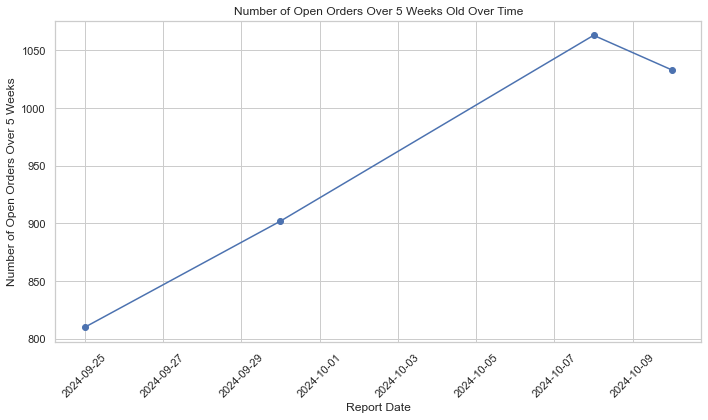

Trend of Open Orders Over 5 Weeks Old:
  Report Date  Open Orders Over 5 Weeks
0  2024-09-25                       810
1  2024-09-30                       902
2  2024-10-08                      1063
3  2024-10-10                      1033

Interpretation:
As of 2024-09-25, there were 810 open orders over 5 weeks old.
As of 2024-09-30, there were 902 open orders over 5 weeks old.
As of 2024-10-08, there were 1063 open orders over 5 weeks old.
As of 2024-10-10, there were 1033 open orders over 5 weeks old.

The number of open orders over 5 weeks old is not consistently decreasing. Further analysis is needed.


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import os

# Set visualization style
sns.set(style='whitegrid')

# Define the directory where reports are stored
report_dir = 'reports/'

# List of report files
report_files = [
    'Master Capelli Report Sheet - 9_25_24 Orders.csv',
    'Master Capelli Report Sheet - 9_30_24 Orders.csv',
    'Master Capelli Report Sheet - 10_8_24 Orders.csv',
    'Master Capelli Report Sheet - 10_10_24 Orders.csv'
]

# Initialize an empty list to store DataFrames
df_list = []

for file in report_files:
    # Combine directory and file name
    file_path = os.path.join(report_dir, file)
    
    # Read each CSV file
    df = pd.read_csv(file_path)
    
    # Extract the report date from the filename using regex
    match = re.search(r'- (\d{1,2}_\d{1,2}_\d{2}) Orders\.csv', file)
    if match:
        date_str = match.group(1)
        # Convert date string to datetime object
        report_date = pd.to_datetime(date_str, format='%m_%d_%y')
    else:
        # If no date found, set to NaT (Not a Time)
        report_date = pd.NaT
    
    # Add the extracted report date to the DataFrame
    df['Report Date'] = report_date
    
    # Append the DataFrame to the list
    df_list.append(df)

# Combine all DataFrames into one
data = pd.concat(df_list, ignore_index=True)

# Preprocess Data
# Convert date columns to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data['Report Date'] = pd.to_datetime(data['Report Date'], errors='coerce')

# Ensure numeric columns are properly typed
numeric_columns = ['Shipped Quantity', 'Unshipped Quantity']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values
data.fillna({'Shipped Quantity': 0, 'Unshipped Quantity': 0}, inplace=True)
data['Combined Order Status'] = data['Combined Order Status'].fillna('Unknown')

# Standardize text columns
data['Order Status'] = data['Order Status'].str.strip().str.lower()
data['Combined Order Status'] = data['Combined Order Status'].str.strip().str.lower()

# Define a function to categorize orders
def categorize_order(row):
    if row['Combined Order Status'] in ['open', 'partially shipped']:
        order_age = (row['Report Date'] - row['Order Date']).days
        if order_age > 35:  # 5 weeks * 7 days
            return 'Outstanding Over 5 Weeks'
        else:
            return 'Outstanding Under 5 Weeks'
    else:
        return 'Other'

# Apply the function to categorize orders
data['Order Category'] = data.apply(categorize_order, axis=1)

# Analyze the number of open orders over 5 weeks old for each report date
trend_data = []

for report_date in sorted(data['Report Date'].dropna().unique()):
    df_report = data[data['Report Date'] == report_date]
    
    # Number of open orders over 5 weeks old
    open_over_5_weeks = df_report[df_report['Order Category'] == 'Outstanding Over 5 Weeks']
    num_open_over_5_weeks = open_over_5_weeks['Order ID'].nunique()
    
    trend_data.append({
        'Report Date': report_date,
        'Open Orders Over 5 Weeks': num_open_over_5_weeks
    })

trend_df = pd.DataFrame(trend_data)

# Plot the number of open orders over 5 weeks old over time
plt.figure(figsize=(10, 6))
plt.plot(trend_df['Report Date'], trend_df['Open Orders Over 5 Weeks'], marker='o')
plt.title('Number of Open Orders Over 5 Weeks Old Over Time')
plt.xlabel('Report Date')
plt.ylabel('Number of Open Orders Over 5 Weeks')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the trend data
print("Trend of Open Orders Over 5 Weeks Old:")
print(trend_df)

# Interpretation
print("\nInterpretation:")
for i in range(len(trend_df)):
    date = trend_df.loc[i, 'Report Date'].strftime('%Y-%m-%d')
    count = trend_df.loc[i, 'Open Orders Over 5 Weeks']
    print(f"As of {date}, there were {count} open orders over 5 weeks old.")

# Determine if the situation is improving
if trend_df['Open Orders Over 5 Weeks'].is_monotonic_decreasing:
    print("\nThe number of open orders over 5 weeks old is decreasing over time. The situation is improving.")
else:
    print("\nThe number of open orders over 5 weeks old is not consistently decreasing. Further analysis is needed.")


From 2024-09-25 to 2024-09-30, 272 orders became over 5 weeks old.
From 2024-09-30 to 2024-10-08, 312 orders became over 5 weeks old.
From 2024-10-08 to 2024-10-10, 65 orders became over 5 weeks old.
From 2024-09-25 to 2024-09-30, 669 orders were shipped, and 258 new orders were added.
From 2024-09-30 to 2024-10-08, 483 orders were shipped, and 331 new orders were added.
From 2024-10-08 to 2024-10-10, 164 orders were shipped, and 79 new orders were added.

Top clubs contributing to new over 5 weeks old orders from 2024-09-25 to 2024-09-30:
Series([], Name: Club_curr, dtype: int64)

Top clubs contributing to new over 5 weeks old orders from 2024-09-30 to 2024-10-08:
Rush Idaho              37
Rush Florida            29
Rush Tennessee Lobos    25
Rush Hawaii             24
Rush Twin Cities        20
Name: Club_curr, dtype: int64

Top clubs contributing to new over 5 weeks old orders from 2024-10-08 to 2024-10-10:
Rush Florida         8
Rush North Denver    5
Rush Ny Rochester    5
Rush T

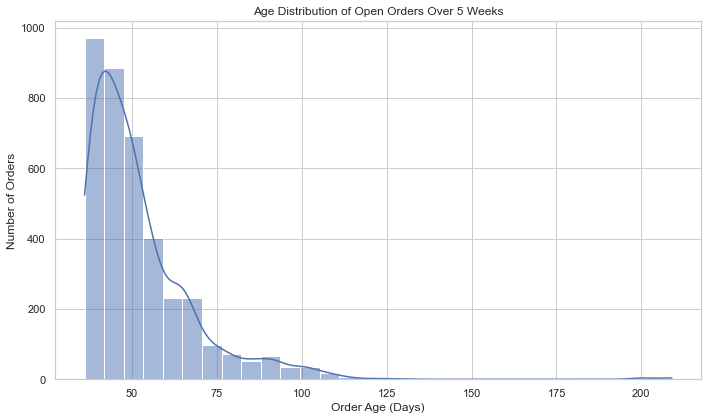


Combined Analysis Data:
  Order ID  From Date  New Orders Over 5 Weeks    To Date  Orders Shipped  \
0      NaN 2024-09-25                    272.0 2024-09-30             669   
1      NaN 2024-09-30                    312.0 2024-10-08             483   
2      NaN 2024-10-08                     65.0 2024-10-10             164   

   New Orders  Net Change Over 5 Weeks Orders  
0         258                          -397.0  
1         331                          -171.0  
2          79                           -99.0  


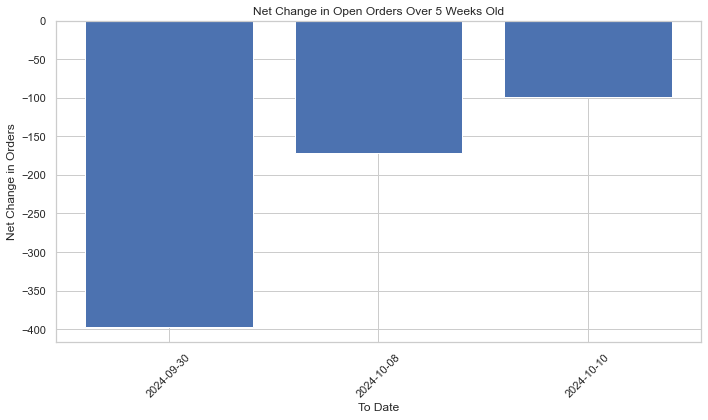

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import os

# Set visualization style
sns.set(style='whitegrid')

# Define the directory where reports are stored
report_dir = 'reports/'

# List of report files
report_files = [
    'Master Capelli Report Sheet - 9_25_24 Orders.csv',
    'Master Capelli Report Sheet - 9_30_24 Orders.csv',
    'Master Capelli Report Sheet - 10_8_24 Orders.csv',
    'Master Capelli Report Sheet - 10_10_24 Orders.csv'
]

# Initialize an empty list to store DataFrames
df_list = []

for file in report_files:
    # Combine directory and file name
    file_path = os.path.join(report_dir, file)
    
    # Read each CSV file
    df = pd.read_csv(file_path)
    
    # Extract the report date from the filename using regex
    match = re.search(r'- (\d{1,2}_\d{1,2}_\d{2}) Orders\.csv', file)
    if match:
        date_str = match.group(1)
        # Convert date string to datetime object
        report_date = pd.to_datetime(date_str, format='%m_%d_%y')
    else:
        # If no date found, set to NaT (Not a Time)
        report_date = pd.NaT
    
    # Add the extracted report date to the DataFrame
    df['Report Date'] = report_date
    
    # Append the DataFrame to the list
    df_list.append(df)

# Combine all DataFrames into one
data = pd.concat(df_list, ignore_index=True)

# Preprocess Data
# Convert date columns to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data['Report Date'] = pd.to_datetime(data['Report Date'], errors='coerce')

# Ensure numeric columns are properly typed
numeric_columns = ['Shipped Quantity', 'Unshipped Quantity']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values
data.fillna({'Shipped Quantity': 0, 'Unshipped Quantity': 0}, inplace=True)
data['Combined Order Status'] = data['Combined Order Status'].fillna('Unknown')

# Standardize text columns
data['Order Status'] = data['Order Status'].str.strip().str.lower()
data['Combined Order Status'] = data['Combined Order Status'].str.strip().str.lower()

# Define a function to categorize orders
def categorize_order(row):
    if row['Combined Order Status'] in ['open', 'partially shipped']:
        order_age = (row['Report Date'] - row['Order Date']).days
        if order_age > 35:  # 5 weeks * 7 days
            return 'Outstanding Over 5 Weeks'
        else:
            return 'Outstanding Under 5 Weeks'
    else:
        return 'Other'

# Apply the function to categorize orders
data['Order Category'] = data.apply(categorize_order, axis=1)

# Ensure 'Order ID' is of type string to prevent issues during merging
data['Order ID'] = data['Order ID'].astype(str)

# Analysis 1: Determine the number of orders becoming over 5 weeks old between each report date

# Create a pivot table with 'Order ID' and 'Order Category' for each 'Report Date'
pivot_tables = {}
for report_date in sorted(data['Report Date'].dropna().unique()):
    df_report = data[data['Report Date'] == report_date]
    pivot_tables[report_date] = df_report[['Order ID', 'Order Category']].drop_duplicates().set_index('Order ID')

# Sort report dates for chronological order
sorted_report_dates = sorted(pivot_tables.keys())

# Initialize DataFrame to store changes
changes_df = pd.DataFrame(columns=['Order ID'])

# Loop through the report dates to find orders that became over 5 weeks old
for i in range(1, len(sorted_report_dates)):
    prev_date = sorted_report_dates[i-1]
    curr_date = sorted_report_dates[i]
    prev_pivot = pivot_tables[prev_date]
    curr_pivot = pivot_tables[curr_date]
    
    # Find orders that were not over 5 weeks old in prev_date but are over 5 weeks old in curr_date
    merged = prev_pivot.join(curr_pivot, lsuffix='_prev', rsuffix='_curr', how='outer')
    condition = (merged['Order Category_prev'] != 'Outstanding Over 5 Weeks') & \
                (merged['Order Category_curr'] == 'Outstanding Over 5 Weeks')
    new_over_5_weeks_orders = merged[condition].reset_index()
    num_new_over_5_weeks_orders = new_over_5_weeks_orders['Order ID'].nunique()
    
    # Store the result
    changes_df = changes_df.append({
        'From Date': pd.Timestamp(prev_date),  # Convert numpy.datetime64 to pd.Timestamp for consistency
        'To Date': pd.Timestamp(curr_date),
        'New Orders Over 5 Weeks': num_new_over_5_weeks_orders
    }, ignore_index=True)
    
    print(f"From {pd.Timestamp(prev_date).date()} to {pd.Timestamp(curr_date).date()}, {num_new_over_5_weeks_orders} orders became over 5 weeks old.")

# Analysis 2: Inflow and Outflow of Orders

# For each report date, calculate the number of orders shipped since the last report
shipment_data = []

for i in range(1, len(sorted_report_dates)):
    prev_date = sorted_report_dates[i-1]
    curr_date = sorted_report_dates[i]
    prev_df = data[data['Report Date'] == prev_date][['Order ID', 'Combined Order Status']].drop_duplicates()
    curr_df = data[data['Report Date'] == curr_date][['Order ID', 'Combined Order Status']].drop_duplicates()
    
    # Merge to compare statuses
    merged_status = prev_df.merge(curr_df, on='Order ID', how='outer', suffixes=('_prev', '_curr'))
    
    # Identify orders that changed from 'open' or 'partially shipped' to 'shipped'
    condition_shipped = merged_status['Combined Order Status_prev'].isin(['open', 'partially shipped']) & \
                        (merged_status['Combined Order Status_curr'] == 'shipped')
    orders_shipped = merged_status[condition_shipped]['Order ID'].nunique()
    
    # Identify new orders added in the current period
    new_orders = curr_df[~curr_df['Order ID'].isin(prev_df['Order ID'])]['Order ID'].nunique()
    
    shipment_data.append({
        'From Date': pd.Timestamp(prev_date),
        'To Date': pd.Timestamp(curr_date),
        'Orders Shipped': orders_shipped,
        'New Orders': new_orders
    })
    
    print(f"From {pd.Timestamp(prev_date).date()} to {pd.Timestamp(curr_date).date()}, {orders_shipped} orders were shipped, and {new_orders} new orders were added.")

# Convert shipment_data to DataFrame
shipment_df = pd.DataFrame(shipment_data)

# Analysis 3: Clubs Contributing to the Increase

# Identify which clubs have the most orders becoming over 5 weeks old
club_contributions = {}

for i in range(1, len(sorted_report_dates)):
    prev_date = sorted_report_dates[i-1]
    curr_date = sorted_report_dates[i]
    prev_df = data[data['Report Date'] == prev_date]
    curr_df = data[data['Report Date'] == curr_date]
    
    # Merge data on 'Order ID'
    merged = prev_df[['Order ID', 'Order Category', 'Club']].merge(
        curr_df[['Order ID', 'Order Category', 'Club']], 
        on='Order ID', how='outer', suffixes=('_prev', '_curr')
    )
    
    # Find orders that became over 5 weeks old
    condition = (merged['Order Category_prev'] != 'Outstanding Over 5 Weeks') & \
                (merged['Order Category_curr'] == 'Outstanding Over 5 Weeks')
    new_over_5_weeks_orders = merged[condition]
    
    # Count by club
    club_counts = new_over_5_weeks_orders['Club_curr'].value_counts()
    club_contributions[(prev_date, curr_date)] = club_counts

    # Display top contributing clubs
    print(f"\nTop clubs contributing to new over 5 weeks old orders from {pd.Timestamp(prev_date).date()} to {pd.Timestamp(curr_date).date()}:")
    print(club_counts.head())

# Analysis 4: Age Distribution of Open Orders Over 5 Weeks

# Combine all open orders over 5 weeks old across all report dates
all_over_5_weeks = data[data['Order Category'] == 'Outstanding Over 5 Weeks'].copy()

# Calculate the age of each order
all_over_5_weeks['Order Age (Days)'] = (all_over_5_weeks['Report Date'] - all_over_5_weeks['Order Date']).dt.days

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_over_5_weeks['Order Age (Days)'], bins=30, kde=True)
plt.title('Age Distribution of Open Orders Over 5 Weeks')
plt.xlabel('Order Age (Days)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Analysis 5: Identify Potential Reasons for Increase

# Combine shipment and new over 5 weeks data
analysis_df = changes_df.merge(shipment_df, on=['From Date', 'To Date'])

# Calculate net change in over 5 weeks orders
analysis_df['Net Change Over 5 Weeks Orders'] = analysis_df['New Orders Over 5 Weeks'] - analysis_df['Orders Shipped']

print("\nCombined Analysis Data:")
print(analysis_df)

# Visualize the net change
plt.figure(figsize=(10, 6))
plt.bar(analysis_df['To Date'].dt.strftime('%Y-%m-%d'), analysis_df['Net Change Over 5 Weeks Orders'])
plt.title('Net Change in Open Orders Over 5 Weeks Old')
plt.xlabel('To Date')
plt.ylabel('Net Change in Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


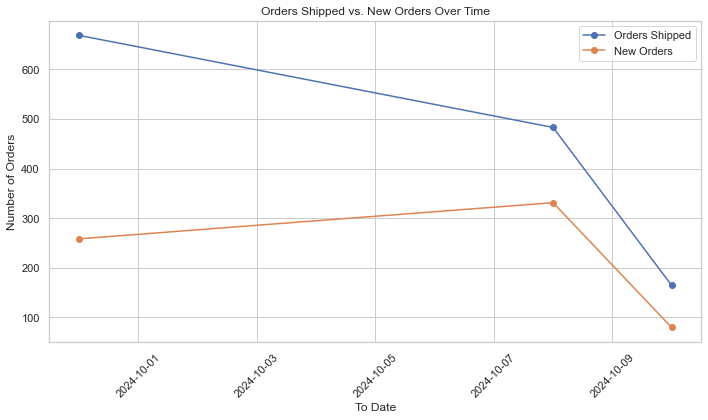

In [10]:
# Plot Orders Shipped and New Orders
plt.figure(figsize=(10, 6))
plt.plot(shipment_df['To Date'], shipment_df['Orders Shipped'], marker='o', label='Orders Shipped')
plt.plot(shipment_df['To Date'], shipment_df['New Orders'], marker='o', label='New Orders')
plt.title('Orders Shipped vs. New Orders Over Time')
plt.xlabel('To Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph displays the total number of open orders exceeding five weeks in age at each reporting date. The upward trend illustrates that the backlog of overdue orders is increasing over time. Despite ongoing shipping efforts, the accumulation of aging orders suggests that the fulfillment capacity is not keeping pace with the volume of orders becoming overdue. This visualization underscores the need for strategies to accelerate order processing and reduce the backlog.

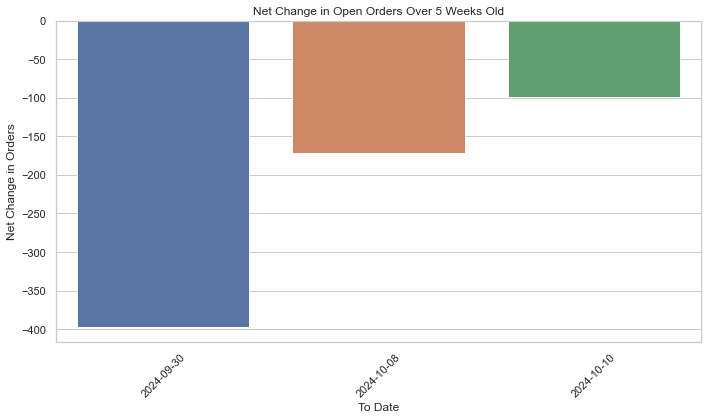

In [11]:
# Plot Net Change in Open Orders Over 5 Weeks Old
plt.figure(figsize=(10, 6))
sns.barplot(x=analysis_df['To Date'].dt.strftime('%Y-%m-%d'), y='Net Change Over 5 Weeks Orders', data=analysis_df)
plt.title('Net Change in Open Orders Over 5 Weeks Old')
plt.xlabel('To Date')
plt.ylabel('Net Change in Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


These graphs compare the number of orders shipped to the number of new orders received during each period. From September 25 to October 10, the number of new orders added (258, 331, and 79 respectively) is substantial, and while a significant number of orders were shipped, the influx of new orders and orders becoming overdue is still higher. This imbalance indicates that the current shipping rate is insufficient to decrease the overall backlog, emphasizing the need to enhance fulfillment operations.

AttributeError: 'numpy.datetime64' object has no attribute 'date'

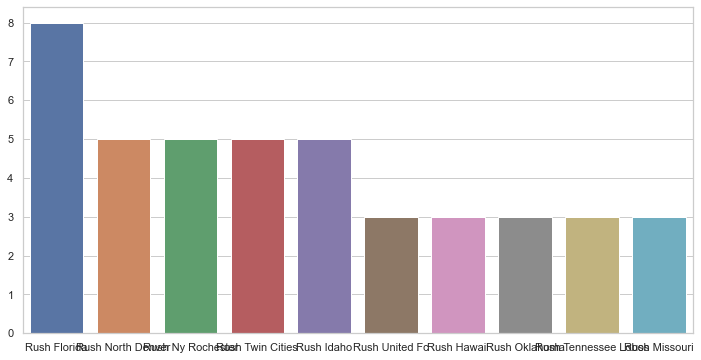

In [13]:
# For the last period, get the top clubs contributing to over 5 weeks orders
last_period = (sorted_report_dates[-2], sorted_report_dates[-1])
club_counts_last_period = club_contributions[last_period]

plt.figure(figsize=(12, 6))
sns.barplot(x=club_counts_last_period.index[:10], y=club_counts_last_period.values[:10])
plt.title(f'Top 10 Clubs Contributing to New Over 5 Weeks Orders from {last_period[0].date()} to {last_period[1].date()}')
plt.xlabel('Club')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
